In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid

import numpy as np
from PIL import Image
import cv2
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

import glob
import os
import copy
import time
import csv
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
data_dir = 'gdrive/MyDrive/unet_attention_training'

In [13]:
class SegmentationDataset(Dataset):
    """Segmentation Dataset"""

    def __init__(self,
                 root_dir,
                 image_folder,
                 mask_folder,
                 transform=None,
                 image_colormode='rgb',
                 mask_colormode='grayscale',
                 seed=42,
                 fraction=0.7,
                 subset=None):
        """
        Args:
            image_folder (string) = 'Images' : Name of the folder which contains the Images.
            mask_folder (string)  = 'Masks : Name of the folder which contains the Masks.
            transform (callable, optional): Optional transform to be applied on a sample.
            seed: Specify a seed for the train and test split
            fraction: A float value from 0 to 1 which specifies the validation split fraction
            subset: 'Train' or 'Test' to select the appropriate set.
            image_colormode: 'rgb' or 'grayscale'
            mask_colormode: 'rgb' or 'grayscale'
        """
        self.color_dict = {'rgb': 1, 'grayscale': 0}
        assert (image_colormode in ['rgb', 'grayscale'])
        assert (mask_colormode in ['rgb', 'grayscale'])

        self.imagecolorflag = self.color_dict[image_colormode]
        self.maskcolorflag = self.color_dict[mask_colormode]
        self.root_dir = root_dir
        self.transform = transform

        if not fraction:
            self.image_names = sorted(
                glob.glob(os.path.join(self.root_dir, image_folder, '*')))
            self.mask_names = sorted(
                glob.glob(os.path.join(self.root_dir, mask_folder, '*')))
        else:
            assert (subset in ['training', 'test'])
            self.fraction = fraction
            self.image_list = np.array(
                sorted(glob.glob(os.path.join(self.root_dir, image_folder, '*'))))
            self.mask_list = np.array(
                sorted(glob.glob(os.path.join(self.root_dir, mask_folder, '*'))))
            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                self.mask_list = self.mask_list[indices]
            if subset == 'training':
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[int(
                    np.ceil(len(self.image_list) * (1 - self.fraction))):]
                self.mask_names = self.mask_list[int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img_name = self.image_names[idx]
        if self.imagecolorflag:
            image = cv2.imread(img_name)
            image = cv2.copyMakeBorder(image, top=4, bottom=4, left=6, right=5,
                                       borderType=cv2.BORDER_CONSTANT)

        else:
            image = cv2.imread(img_name)
            image = cv2.copyMakeBorder(image, top=4, bottom=4, left=6, right=5,
                                       borderType=cv2.BORDER_CONSTANT)

        msk_name = self.mask_names[idx]
        if self.maskcolorflag:
            mask = np.array(Image.open(msk_name)).transpose(2, 0, 1)
            mask = cv2.copyMakeBorder(mask, top=4, bottom=4, left=6, right=5,
                                      borderType=cv2.BORDER_CONSTANT)
        else:
            mask = np.array(Image.open(msk_name))
            mask = cv2.copyMakeBorder(mask, top=4, bottom=4, left=6, right=5,
                                      borderType=cv2.BORDER_CONSTANT)

        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [15]:
class Resize(object):
    """Resize image and/or masks."""

    def __init__(self, image_resize, mask_resize):
        self.image_resize = image_resize
        self.mask_resize = mask_resize

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        if len(image.shape) == 3:
            image = image.transpose(1, 2, 0)
        if len(mask.shape) == 3:
            mask = mask.transpose(1, 2, 0)
        mask = cv2.resize(mask, self.mask_resize, cv2.INTER_AREA)
        image = cv2.resize(image, self.image_resize, cv2.INTER_AREA)
        if len(image.shape) == 3:
            image = image.transpose(2, 0, 1)
        if len(mask.shape) == 3:
            mask = mask.transpose(2, 0, 1)

        return {'image': image,
                'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, mask_resize=None, image_resize=None):
        image, mask = sample['image'], sample['mask']
        image = image.transpose(2, 0, 1)

        if len(mask.shape) == 2:
            mask = mask.reshape((1,) + mask.shape)
        if len(image.shape) == 2:
            image = image.reshape((1,) + image.shape)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}


class Normalize(object):
    """Normalize image"""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        return {'image': image.type(torch.FloatTensor) / 255,
                'mask': mask.type(torch.FloatTensor) / 255}


class HorizontalFlip(object):
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        if np.random.random() < self.prob:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)

        return {'image': image,
                'mask': mask}


class ApplyClaheColor(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

        return {'image': img_output,
                'mask': mask}


class ApplyClahe(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        clahe = cv2.createCLAHE(clipLimit=2.0)
        image = clahe.apply(image)

        return {'image': image,
                'mask': mask}


class Color2Gray(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return {'image': image,
                'mask': mask}


class Denoise(object):

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = cv2.bilateralFilter(image, d=5, sigmaColor=9, sigmaSpace=9)
        return {'image': image,
                'mask': mask}


def get_data_loaders(data_dir, image_folder='images', mask_folder='1st_manual', batch_size=4):
    data_transforms = {
        # Resize((592, 576), (592, 576)),
        'training': transforms.Compose([HorizontalFlip(), ApplyClaheColor(), Denoise(), ToTensor(), Normalize()]),
        'test': transforms.Compose([HorizontalFlip(), ApplyClaheColor(), Denoise(), ToTensor(), Normalize()]),
    }

    image_datasets = {x: SegmentationDataset(root_dir=data_dir,
                                             transform=data_transforms[x],
                                             image_folder=image_folder,
                                             mask_folder=mask_folder,
                                             subset=x)
                      for x in ['training', 'test']}

    data_loaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                    for x in ['training', 'test']}

    return data_loaders


def plot_batch_from_dataloader(dataloaders, batch_size):
    """

    :param dataloaders: dataset dataloaders
    :param batch_size: size of the batch to plot
    :return: void
    """
    batch = next(iter(dataloaders['training']))

    for i in range(batch_size):

        np_img = batch['image'][i].numpy()
        np_mask = batch['mask'][i].numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(np.transpose(np_img, (1, 2, 0)))
        ax[1].imshow(np.squeeze(np.transpose(np_mask, (1, 2, 0))), cmap='gray')
        plt.show()


def myimshow(img, unnormalize=False):
    """

    :param img: tensor of images, first dimension is number of images in the batch
    :param unnormalize: whenever to unnormalize the image before plotting
    :return: void
    """
    if unnormalize:
        img = img * 255

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img[0], (1, 2, 0)))
    plt.show()


def images_generator(path):
    for img_name in glob.glob(os.path.join(path, '*')):
        image = np.array(Image.open(img_name)).transpose(2, 0, 1)
        yield image

In [16]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result


class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):

        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [17]:
def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, show_images=False):
    since = time.time()
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_dice_coeff', 'test_dice_coeff']
    train_epoch_losses = []
    test_epoch_losses = []
    for epoch in range(1, num_epochs + 1):

        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss = 0.0
        batch_test_loss = 0.0

        for phase in ['training', 'test']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in iter(dataloaders[phase]):

                if show_images:
                    grid_img = make_grid(sample['image'])
                    grid_img = grid_img.permute(1, 2, 0)
                    plt.imshow(grid_img)
                    plt.show()

                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history only in training phase
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                    # back-propagation
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                        # accumulate batch loss
                        batch_train_loss += loss.item() * sample['image'].size(0)

                    else:
                        batch_test_loss += loss.item() * sample['image'].size(0)

            # save epoch losses
            if phase == 'training':
                epoch_train_loss = batch_train_loss / len(dataloaders['training'])
                train_epoch_losses.append(epoch_train_loss)
            else:
                epoch_test_loss = batch_test_loss / len(dataloaders['test'])
                test_epoch_losses.append(epoch_test_loss)

            batchsummary['epoch'] = epoch
            # batchsummary[f'{phase}_loss'] = epoch_train_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))

        best_loss = np.max(batchsummary['test_dice_coeff'])
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(
            f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

    # summary
    print('Best dice coefficient: {:4f}'.format(best_loss))

    return model, train_epoch_losses, test_epoch_losses

In [18]:
batch_size = 4
epochs = 150
bpath = '.'
dataloaders = get_data_loaders(data_dir, batch_size=batch_size)

def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = FocalLoss(gamma=2)

    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses


trained_model, train_epoch_losses, test_epoch_losses = train()

Epoch 1/150
----------
training Loss: 0.1137
test Loss: 0.1522
			 train_dice_coeff: 0.06470339062313239, test_dice_coeff: 0.0
Epoch 2/150
----------
training Loss: 0.0585
test Loss: 0.5510
			 train_dice_coeff: 0.0896054059267044, test_dice_coeff: 0.12693917155265808
Epoch 3/150
----------
training Loss: 0.0436
test Loss: 1.5498
			 train_dice_coeff: 0.02913393701116244, test_dice_coeff: 0.13119145333766938
Epoch 4/150
----------
training Loss: 0.0355
test Loss: 0.6000
			 train_dice_coeff: 0.008732986015578112, test_dice_coeff: 0.12251646816730499
Epoch 5/150
----------
training Loss: 0.0320
test Loss: 0.1550
			 train_dice_coeff: 0.026114992176493008, test_dice_coeff: 0.0
Epoch 6/150
----------
training Loss: 0.0262
test Loss: 0.0785
			 train_dice_coeff: 0.08173056940237682, test_dice_coeff: 0.015251078270375728
Epoch 7/150
----------
training Loss: 0.0249
test Loss: 0.0785
			 train_dice_coeff: 0.1977724532286326, test_dice_coeff: 0.07072539180517197
Epoch 8/150
----------
trainin

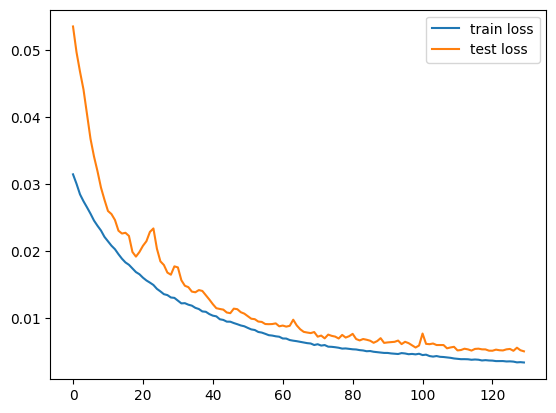

In [19]:
train_plot, = plt.plot(range(len(train_epoch_losses)-20), train_epoch_losses[20:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-20), test_epoch_losses[20:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()

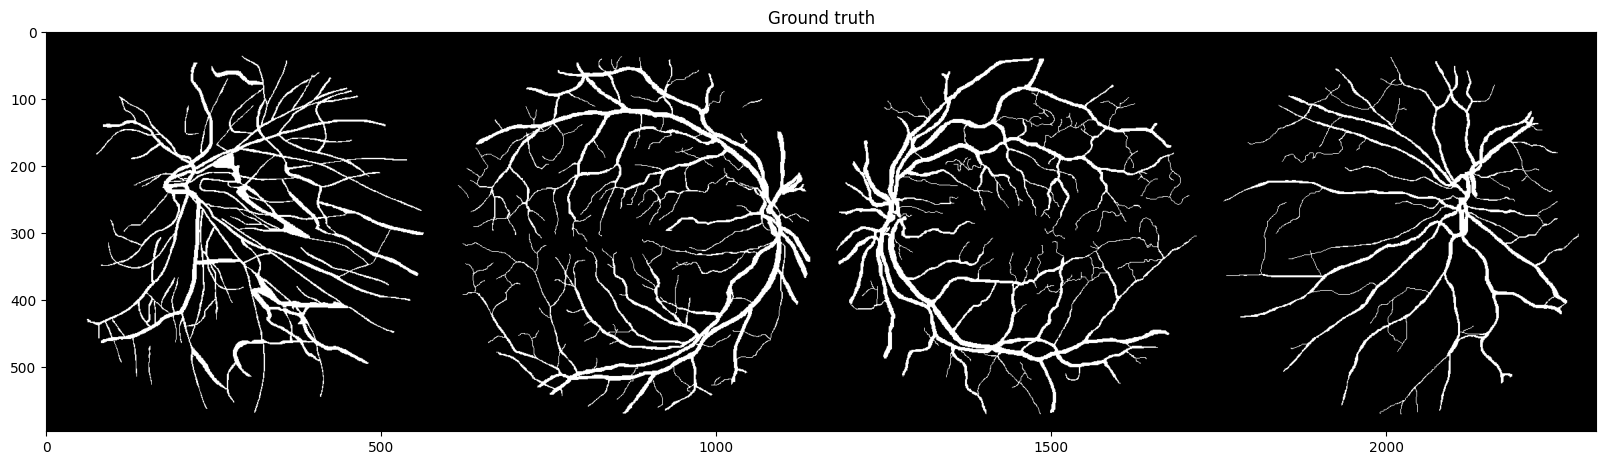

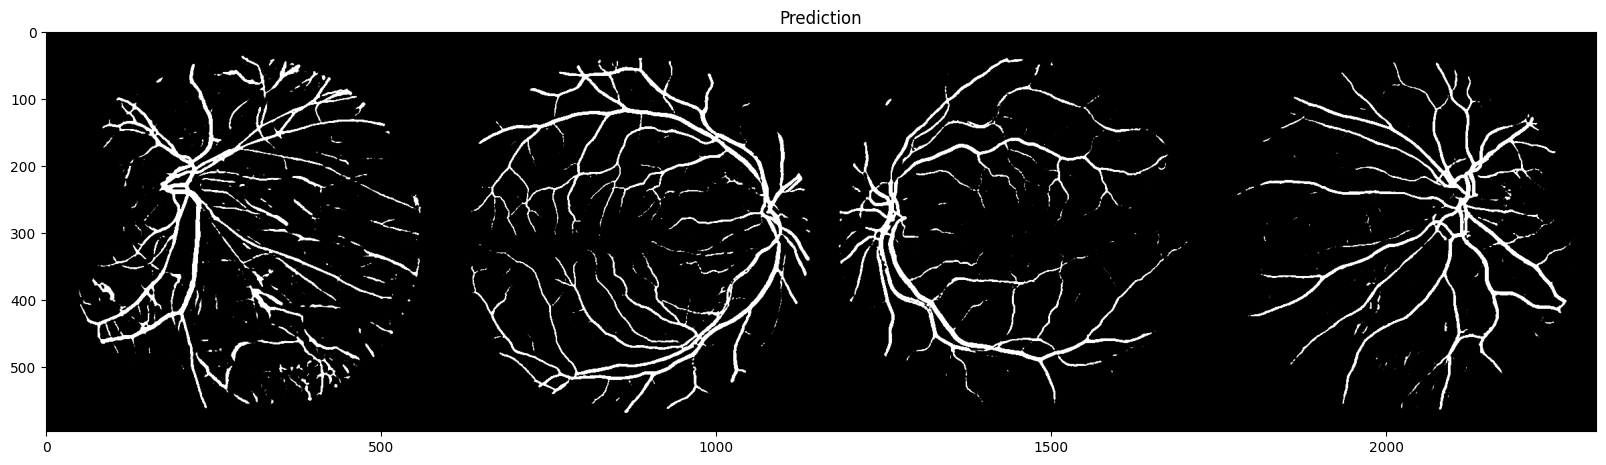

In [21]:
dataiter = iter(dataloaders['test'])
batch = next(dataiter)

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(batch['mask'])
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Ground truth')
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
inputs = batch['image'].to(device)
prediction = trained_model(inputs).detach().cpu()

prediction[prediction >= 0.5] = 1

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(prediction)
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Prediction')
plt.show()